In [1]:
import torch
from torch import nn
import torch.optim as optim
from fastai.vision.all import *
import matplotlib.pyplot as plt
from models_module import my_models
from train_module import training_functions
from batchflow.models.torch import Encoder
GRAPH_PATH = "./data/graphs/"

In [2]:
in_channels = 3
downsample_depth = 2
out_channels = 10
device = "cuda:3"


batch_size = 10
epoch_num = 30
strides_main_branch = [[1, 1], [1, 1]]
strides_main_branch.extend([[2, 1], [1, 1]]*3)
strides_identity_branch = [1, 1]
strides_identity_branch.extend([2, 1]*3)


config = {
    'inputs/images/shape': (3, 160, 160), # can be commented
    'initial_block/inputs': 'images', # can be commented   
    'device': device,

    'initial_block': {
        'layout': 'cnap', 
        'filters': 64,
        'strides': 2
    },

    'body/encoder': {
        'num_stages': 8,
        'order': ['block']
    },    
    'body/encoder/blocks': {
        'layout': 'Rcna cn+a',
        'filters':  [64, 64, 128, 128, 256, 256, 512, 512],
        'branch': [{'layout': 'cn', 'filters': f, 'strides': s}
                   for f, s in  zip(
                       [64, 64, 128, 128, 256, 256, 512, 512],
                       strides_identity_branch
                   )],
        'strides': strides_main_branch
    },
    
    'head':{
        'layout': 'Vdf',
        'dropout_rate': 0.3,
        'units': out_channels
    },
    
    'loss': 'ce',
    'optimizer': 'Adam'
}

net = Encoder(config)
train_loss = net.loss[0]
optimizer = net.optimizer

In [3]:
net.short_repr()

Sequential(
  (initial_block): ConvBlock
  layout=cnap
    Layer 0,  letter "c": (None, 3, 160, 160) -> (None, 64, 80, 80)
    Layer 1,  letter "n": (None, 64, 80, 80) -> (None, 64, 80, 80)
    Layer 2,  letter "a": (None, 64, 80, 80) -> (None, 64, 80, 80)
    Layer 3,  letter "p": (None, 64, 80, 80) -> (None, 64, 40, 40)
    
  (body): Sequential(
    (encoder): EncoderModule(
      (block-0): ConvBlock
      DefaultBlock
        layout=Rcnacn+a
          Layer 0,    skip "R": (None, 64, 40, 40) -> (None, 64, 40, 40)
          Layer 1,  letter "c": (None, 64, 40, 40) -> (None, 64, 40, 40)
          Layer 2,  letter "n": (None, 64, 40, 40) -> (None, 64, 40, 40)
          Layer 3,  letter "a": (None, 64, 40, 40) -> (None, 64, 40, 40)
          Layer 4,  letter "c": (None, 64, 40, 40) -> (None, 64, 40, 40)
          Layer 5,  letter "n": (None, 64, 40, 40) -> (None, 64, 40, 40)
          Layer 6, combine "+": (None, 64, 40, 40)
                                (None, 64, 40, 40) -> (None,

In [4]:
net = net.model

In [5]:
path = URLs.IMAGENETTE_160

In [6]:
trainloader, valloader = training_functions.prepare_train_and_val_dls(path, batch_size, size=160, num_workers=4, device=device)

In [7]:
%%time
net, optimization_history = training_functions.train(net, optimizer, 
                                                     train_loss, epoch_num,
                                                     trainloader, valloader, 
                                                     device, GRAPH_PATH+"ResNet_test_info.jpg")

100%|██████████| 30/30 [25:55<00:00, 51.84s/it]

CPU times: user 24min 52s, sys: 1min 2s, total: 25min 55s
Wall time: 25min 55s


In [8]:
accuracy, conf_matrix, precision, recall, f1 = training_functions.test_metrics(net, device, valloader, out_channels)

print("Test accuracy: ", accuracy)
print("Test precision: ", precision)
print("Test recall: ", recall)
print("Test f-measure: ", f1)

Test accuracy:  0.7877707006369427
Test precision:  0.49118347895154885
Test recall:  0.4445083381253594
Test f-measure:  0.46668175986717986


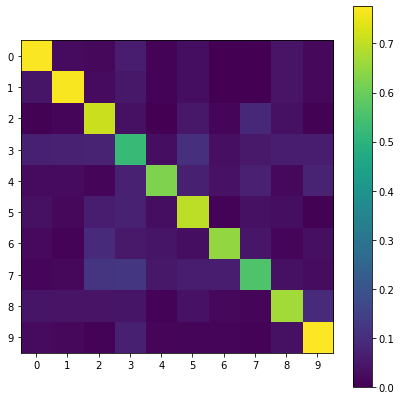

In [9]:
plt.figure(figsize=(7, 7))

plt.imshow(conf_matrix)
plt.xticks(range(conf_matrix.shape[0]))
plt.yticks(range(conf_matrix.shape[0]))
plt.colorbar()
plt.show()

In [10]:
data, labels = valloader.one_batch()

In [11]:
labels_names = ["tench", "English springer", "cassette player", "chain saw", "church", "French horn", "garbage truck", "gas pump", "golf ball", "parachute"]

In [12]:
outputs = net(data.to(device))
_, predicted = torch.max(outputs.detach(), 1)

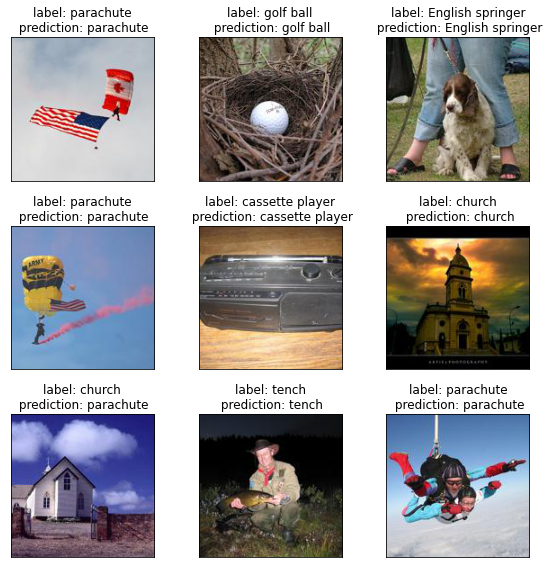

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8,8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    ax.imshow(data[picture_num].cpu().permute(1, 2, 0))
    ax.set_title("label: {}\n prediction: {}".format(labels_names[labels[picture_num]], 
                                                     labels_names[predicted[picture_num]]))

plt.tight_layout()
plt.show()